# L1 norm prior experiment

This code attempts to learn the 8D prior
$J(x) = ||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i)$- using Huber function 

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/L1_prior_8D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Section 3.1: Convex Prior J(x) = ||x||_1
    # S(x,t) is the Moreau Envelope of the L1 norm (Huber function).
    # Per component j: if |x_j| > t: |x_j| - t/2. If |x_j| <= t: x_j^2 / 2t
    
    abs_y = np.abs(y)
    # Mask for |x| <= t
    small_mask = abs_y <= t
    
    # Component-wise values
    comps = np.zeros_like(y)
    comps[small_mask] = (abs_y[small_mask]**2) / (2 * t)
    comps[~small_mask] = abs_y[~small_mask] - (t / 2.0)
    
    # Sum across dimensions (separable)
    return np.sum(comps, axis=1)


def prior_true(y):
    # J(x) = ||x||_1
    return np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 8

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 30000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 102.97100067138672
iteration 0 loss 965.4783935546875


iteration 5000 loss 0.2854249179363251


iteration 10000 loss 0.03077303245663643


iteration 15000 loss 0.011636510491371155


iteration 20000 loss 0.007405476178973913


iteration 25000 loss 0.005089938640594482


iteration 30000 loss 0.0036852716002613306


iteration 35000 loss 0.002770301653072238


iteration 40000 loss 0.0022205845452845097


iteration 45000 loss 0.0018011078936979175


iteration 50000 loss 0.0014939992688596249


iteration 55000 loss 0.0013566820416599512


iteration 60000 loss 0.0011463058181107044


iteration 65000 loss 0.0009919950971379876


iteration 70000 loss 0.0008968531037680805


iteration 75000 loss 0.0008500947151333094


iteration 80000 loss 0.000761703762691468


iteration 85000 loss 0.0007081578369252384


iteration 90000 loss 0.0006553824641741812


iteration 95000 loss 0.0006139521137811244


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0005803141393698752


iteration 105000 loss 0.0005641522002406418


iteration 110000 loss 0.0005362565279938281


iteration 115000 loss 0.0005138046690262854


iteration 120000 loss 0.0004944922402501106


iteration 125000 loss 0.00047438673209398985


iteration 130000 loss 0.0004584175767377019


iteration 135000 loss 0.0004396558797452599


iteration 140000 loss 0.0004233458312228322


iteration 145000 loss 0.0004091892042197287


iteration 150000 loss 0.0003976213629357517


iteration 155000 loss 0.00038470313302241266


iteration 160000 loss 0.0003719931119121611


iteration 165000 loss 0.0003590234264265746


iteration 170000 loss 0.0003476024139672518


iteration 175000 loss 0.0003368002362549305


iteration 180000 loss 0.000327871908666566


iteration 185000 loss 0.00031956651946529746


iteration 190000 loss 0.0003101334150414914


iteration 195000 loss 0.0003009761276189238


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0002929976908490062


iteration 205000 loss 0.0002895565121434629


iteration 210000 loss 0.0002775265311356634


iteration 215000 loss 0.000266759074293077


iteration 220000 loss 0.0002564897877164185


iteration 225000 loss 0.0002473428612574935


iteration 230000 loss 0.00023898018116597086


iteration 235000 loss 0.00023113789211492985


iteration 240000 loss 0.00022385790362022817


iteration 245000 loss 0.0002166062913602218


iteration 250000 loss 0.00021002143330406398


iteration 255000 loss 0.0002030484174611047


iteration 260000 loss 0.00019660060934256762


iteration 265000 loss 0.0001911423314595595


iteration 270000 loss 0.0001862932986114174


iteration 275000 loss 0.00018201785860583186


iteration 280000 loss 0.00017792140715755522


iteration 285000 loss 0.00017400486103724688


iteration 290000 loss 0.0001703618763713166


iteration 295000 loss 0.0001668529730523005


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0001637690293136984


iteration 305000 loss 0.00016211641195695847


iteration 310000 loss 0.00015821147826500237


iteration 315000 loss 0.00015459416317753494


iteration 320000 loss 0.00015121024625841528


iteration 325000 loss 0.00014799910422880203


iteration 330000 loss 0.00014493214257527143


iteration 335000 loss 0.00014200122677721083


iteration 340000 loss 0.00013918435433879495


iteration 345000 loss 0.0001364729687338695


iteration 350000 loss 0.00013387213402893394


iteration 355000 loss 0.0001313883694820106


iteration 360000 loss 0.00012901521404273808


iteration 365000 loss 0.00012671679724007845


iteration 370000 loss 0.0001244694140041247


iteration 375000 loss 0.00012229061394464225


iteration 380000 loss 0.00012019094720017165


iteration 385000 loss 0.00011817598715424538


iteration 390000 loss 0.00011624053149716929


iteration 395000 loss 0.00011437875218689442


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.00011259101302130148


iteration 405000 loss 0.00011222509783692658


iteration 410000 loss 0.00011175810504937544


iteration 415000 loss 0.00011133284715469927


iteration 420000 loss 0.00011092516069766134


iteration 425000 loss 0.00011052782065235078


iteration 430000 loss 0.00011013753100996837


iteration 435000 loss 0.00010975281475111842


iteration 440000 loss 0.0001093731407308951


iteration 445000 loss 0.00010899781045736745


iteration 450000 loss 0.00010862603085115552


iteration 455000 loss 0.00010825749632203951


iteration 460000 loss 0.00010789222869789228


iteration 465000 loss 0.00010752957314252853


iteration 470000 loss 0.00010716982069425285


iteration 475000 loss 0.00010681295680115


iteration 480000 loss 0.00010645882139215246


iteration 485000 loss 0.00010610746539896354


iteration 490000 loss 0.00010575885244179517


iteration 495000 loss 0.00010541318624746054


L2 loss -- Plot

loss -1.0296940803527832


loss -102.51396179199219


loss -201.7156219482422


loss -288.3233642578125


loss -347.2483825683594


loss -389.5307922363281


loss -419.85614013671875


loss -441.1168518066406


loss -455.822021484375


loss -465.2939758300781


loss -471.17315673828125


loss -474.981689453125


loss -477.71759033203125


loss -479.9372253417969


loss -481.9404296875


loss -483.8922119140625


loss -485.8827819824219


loss -487.9561767578125


loss -490.12677001953125


loss -492.39111328125


loss -494.7363586425781


loss -497.14642333984375


loss -499.60565185546875


loss -502.100830078125


loss -504.62139892578125


loss -507.15936279296875


loss -509.70892333984375


loss -512.2659301757812


loss -514.8277587890625


loss -517.3925170898438


loss -519.9586181640625


loss -522.5257568359375


loss -525.0931396484375


loss -527.6607055664062


loss -530.2280883789062


loss -532.7953491210938


loss -535.3624267578125


loss -537.9293823242188


loss -540.49609375


loss -543.0626220703125


final mse:  0.0028882967308163643
max, min: 17.537846 -18.053127
loss -1.0296940803527832


loss -102.44293212890625


loss -201.57005310058594


loss -288.04742431640625


loss -347.31341552734375


loss -389.61846923828125


loss -420.0802307128906


loss -441.31268310546875


loss -456.0159912109375


loss -465.5417785644531


loss -471.42333984375


loss -475.612548828125


loss -479.25982666015625


loss -482.8425598144531


loss -486.5397033691406


loss -490.4102783203125


loss -494.46112060546875


loss -498.6744689941406


loss -503.021728515625


loss -507.47161865234375


loss -511.9945373535156


loss -516.5654907226562


loss -521.16455078125


loss -525.776611328125


loss -530.3907470703125


loss -534.99951171875


loss -539.5977783203125


loss -544.181640625


loss -548.749755859375


loss -553.300537109375


loss -557.834228515625


loss -562.350830078125


loss -566.851318359375


loss -571.3361206054688


loss -575.806396484375


loss -580.2633666992188


loss -584.7081298828125


loss -589.141357421875


loss -593.5645751953125


loss -597.978759765625


final mse:  0.0065636178478598595
max, min: 17.876232 -18.433064


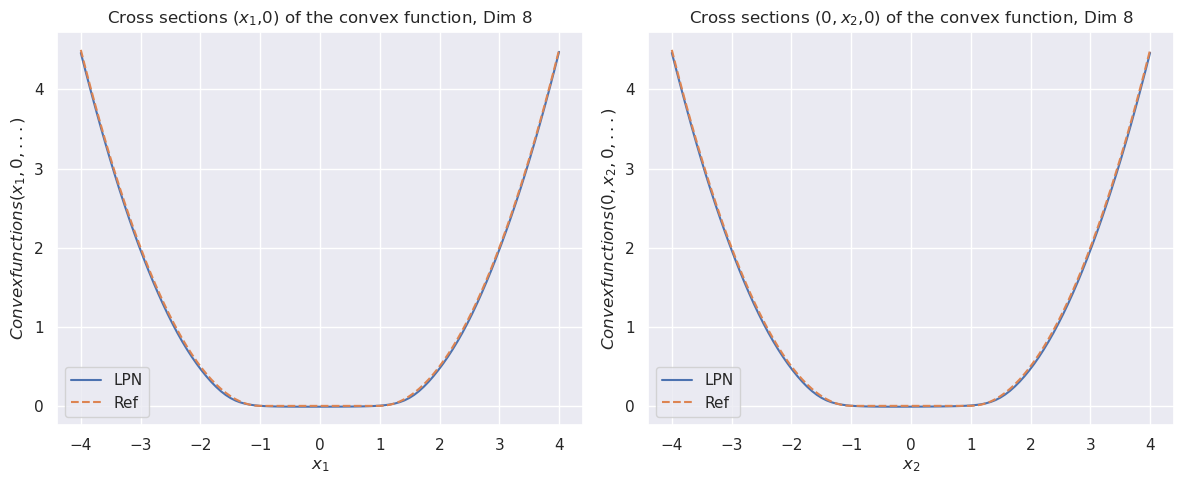

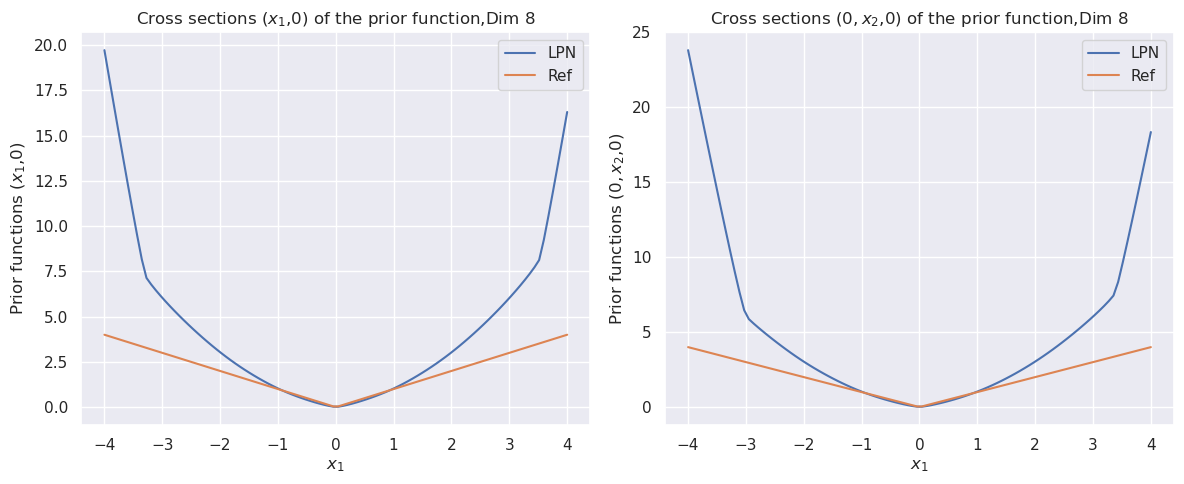

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 368.9856262207031
iteration 0 loss 75.88884735107422


iteration 5000 loss 0.032694436609745026


iteration 10000 loss 0.024864928796887398


iteration 15000 loss 0.019861817359924316


iteration 20000 loss 0.016602391377091408


iteration 25000 loss 0.014080839231610298


iteration 30000 loss 0.012003145180642605


iteration 35000 loss 0.010379629209637642


iteration 40000 loss 0.009092602878808975


iteration 45000 loss 0.009003182873129845


iteration 50000 loss 0.007362911943346262


iteration 55000 loss 0.00820480939000845


iteration 60000 loss 0.005895737558603287


iteration 65000 loss 0.005221379455178976


iteration 70000 loss 0.004681963939219713


iteration 75000 loss 0.004199420101940632


iteration 80000 loss 0.0037638626527041197


iteration 85000 loss 0.0033982896711677313


iteration 90000 loss 0.003254207316786051


iteration 95000 loss 0.0029639441054314375


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0027912617661058903


iteration 105000 loss 0.0026991236954927444


iteration 110000 loss 0.0025777153205126524


iteration 115000 loss 0.0024754286278039217


iteration 120000 loss 0.002383908024057746


iteration 125000 loss 0.002300866646692157


iteration 130000 loss 0.002226315438747406


iteration 135000 loss 0.0021545393392443657


iteration 140000 loss 0.0020878068171441555


iteration 145000 loss 0.0020254987757653


iteration 150000 loss 0.0019672629423439503


iteration 155000 loss 0.0019097839249297976


iteration 160000 loss 0.0018590294057503343


iteration 165000 loss 0.0018099677981808782


iteration 170000 loss 0.0021444254089146852


iteration 175000 loss 0.001712712226435542


iteration 180000 loss 0.0016678940737619996


iteration 185000 loss 0.0016274054069072008


iteration 190000 loss 0.0015878306003287435


iteration 195000 loss 0.0015498683787882328


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0015108182560652494


iteration 205000 loss 0.0014850810403004289


iteration 210000 loss 0.001444667810574174


iteration 215000 loss 0.0014099891996011138


iteration 220000 loss 0.0013776689302176237


iteration 225000 loss 0.00134452641941607


iteration 230000 loss 0.0013119943905621767


iteration 235000 loss 0.0012813383946195245


iteration 240000 loss 0.0012538754381239414


iteration 245000 loss 0.001227166852913797


iteration 250000 loss 0.0012021103175356984


iteration 255000 loss 0.0011780094355344772


iteration 260000 loss 0.0011559652630239725


iteration 265000 loss 0.001132541336119175


iteration 270000 loss 0.0011110070627182722


iteration 275000 loss 0.0010906916577368975


iteration 280000 loss 0.0010701488936319947


iteration 285000 loss 0.0010494058951735497


iteration 290000 loss 0.0010291039943695068


iteration 295000 loss 0.0010109011782333255


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.000994900823570788


iteration 305000 loss 0.0009891412919387221


iteration 310000 loss 0.0009733060142025352


iteration 315000 loss 0.0009578031022101641


iteration 320000 loss 0.0009425985044799745


iteration 325000 loss 0.000927810906432569


iteration 330000 loss 0.0009135021828114986


iteration 335000 loss 0.000899570353794843


iteration 340000 loss 0.000886097433976829


iteration 345000 loss 0.0008730854606255889


iteration 350000 loss 0.0008604629547335207


iteration 355000 loss 0.000848200696054846


iteration 360000 loss 0.0008364246459677815


iteration 365000 loss 0.0008249979582615197


iteration 370000 loss 0.0008139928104355931


iteration 375000 loss 0.0008033483172766864


iteration 380000 loss 0.000793097831774503


iteration 385000 loss 0.00078299903543666


iteration 390000 loss 0.0007730512879788876


iteration 395000 loss 0.000763332936912775


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0007538360659964383


iteration 405000 loss 0.0007526054978370667


iteration 410000 loss 0.0007509373826906085


iteration 415000 loss 0.0007493101875297725


iteration 420000 loss 0.0007477134349755943


iteration 425000 loss 0.000746138219255954


iteration 430000 loss 0.0007445778464898467


iteration 435000 loss 0.000743033888284117


iteration 440000 loss 0.000741503550671041


iteration 445000 loss 0.0007399874739348888


iteration 450000 loss 0.0007384826894849539


iteration 455000 loss 0.0007369918748736382


iteration 460000 loss 0.0007355135749094188


iteration 465000 loss 0.0007340454612858593


iteration 470000 loss 0.0007325900951400399


iteration 475000 loss 0.0007311454974114895


iteration 480000 loss 0.0007297126576304436


iteration 485000 loss 0.000728289654944092


iteration 490000 loss 0.0007268761983141303


iteration 495000 loss 0.0007254722295328975


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


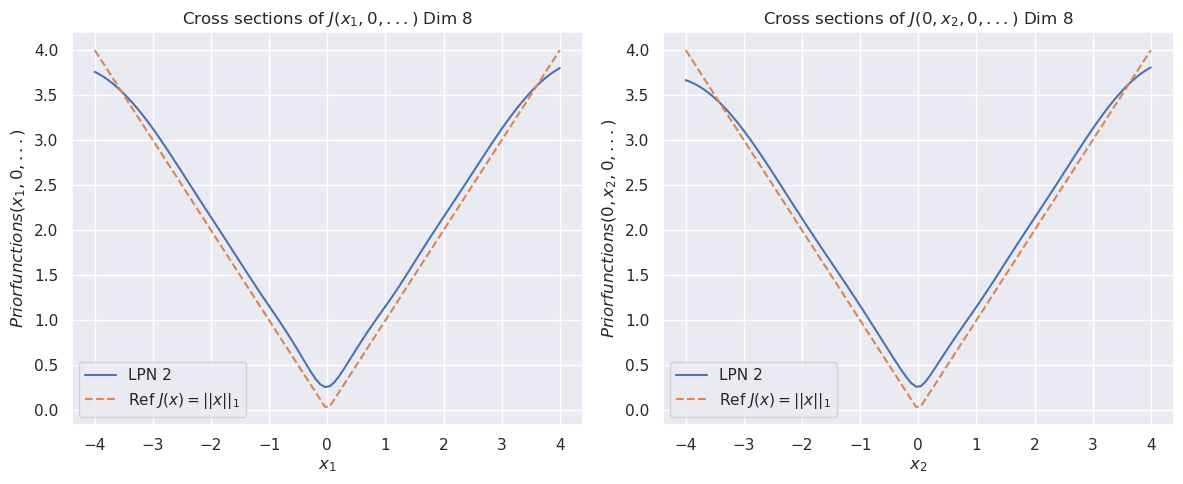

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)